![Roboflow Notebooks banner](https://camo.githubusercontent.com/aec53c2b5fb6ed43d202a0ab622b58ba68a89d654fbe3abab0c0cc8bd1ff424e/68747470733a2f2f696b2e696d6167656b69742e696f2f726f626f666c6f772f6e6f7465626f6f6b732f74656d706c6174652f62616e6e657274657374322d322e706e673f696b2d73646b2d76657273696f6e3d6a6176617363726970742d312e342e33267570646174656441743d31363732393332373130313934)

# Image Retrieval with DINOv2

DINOv2, released by Meta Research in April 2023, implements a self-supervised method of training computer vision models.

DINOv2 was trained using 140 million images without labels. The embeddings generated by DINOv2 can be used for classification, image retrieval, segmentation, and depth estimation. With that said, Meta Research did not release heads for segmentation and depth estimation.

In this guide, we're going to talk through how to build an image-to-image retrieval system with DINOv2. We will:

1. Load a folder of images
2. Compute embeddings for each image
3. Save all the embeddings in a `faiss` index
4. Build the logic to search the index for an image

By the end of this notebook, we'll have a system that we can feed an image to return related images.

Without further ado, let's begin!

## Load Images

In this demo, we're going to build an image search engine for the [COCO 128 dataset](https://universe.roboflow.com/team-roboflow/coco-128) available on Roboflow Universe. First, let's download the dataset from Roboflow and make a list of all the files in the `train` folder on which we'll build our search engine.

To download this dataset, you will need a [free Roboflow account](https://app.roboflow.com).

_Note: You can provide any folder of images you want!_

In [ ]:
! pip install roboflow faiss-gpu supervision

In [4]:
#NOTE: Optional

import roboflow
import os

roboflow.login()

rf = roboflow.Roboflow()

project = rf.workspace("team-roboflow").project("coco-128")
dataset = project.version(2).download("coco")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to COCO-128-2 in coco:: 100%|██████████| 386/386 [00:00<00:00, 978.74it/s]


In [29]:
import os

cwd = os.getcwd()

ROOT_DIR = os.path.join(cwd, "/home/pravaig-20/Downloads/Assignment_CVML_02_04_24/Assignment/datasets/RESISC45_partial/")

# dirs = os.listdir(ROOT_DIR)
# for sub_dir in dirs:   
#     files = [os.path.join(ROOT_DIR, sub_dir, f) for f in files if f.lower().endswith(".jpg")]


import os

def list_files_with_paths(directory):
    file_paths = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            full_path = os.path.join(root, file)
            file_paths.append(full_path)
    return file_paths

# Example usage
directory = ROOT_DIR #"/path/to/your/directory"
files = list_files_with_paths(directory)

In [30]:
files

['/home/pravaig-20/Downloads/Assignment_CVML_02_04_24/Assignment/datasets/RESISC45_partial/ship/ship_598.jpg',
 '/home/pravaig-20/Downloads/Assignment_CVML_02_04_24/Assignment/datasets/RESISC45_partial/ship/ship_042.jpg',
 '/home/pravaig-20/Downloads/Assignment_CVML_02_04_24/Assignment/datasets/RESISC45_partial/ship/ship_212.jpg',
 '/home/pravaig-20/Downloads/Assignment_CVML_02_04_24/Assignment/datasets/RESISC45_partial/ship/ship_514.jpg',
 '/home/pravaig-20/Downloads/Assignment_CVML_02_04_24/Assignment/datasets/RESISC45_partial/ship/ship_677.jpg',
 '/home/pravaig-20/Downloads/Assignment_CVML_02_04_24/Assignment/datasets/RESISC45_partial/ship/ship_104.jpg',
 '/home/pravaig-20/Downloads/Assignment_CVML_02_04_24/Assignment/datasets/RESISC45_partial/ship/ship_077.jpg',
 '/home/pravaig-20/Downloads/Assignment_CVML_02_04_24/Assignment/datasets/RESISC45_partial/ship/ship_070.jpg',
 '/home/pravaig-20/Downloads/Assignment_CVML_02_04_24/Assignment/datasets/RESISC45_partial/ship/ship_228.jpg',
 

## Import Dependencies and Load Model

Next, let's import the remaining dependencie required for our project and load the DINOv2 model. We'll work with the smallest model, `dinov2_vits14` in this guide. You can swap this model out for any checkpoint from the DINOv2 GitHub repository.

We'll also set a `ROOT_DIR`. This refers to the folder in which the images we want to search are stored.

In [7]:
import faiss
import numpy as np
import torch
import torchvision.transforms as T
from PIL import Image
import cv2
import json
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import supervision as sv

In [8]:
dinov2_vits14 = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14")

device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

dinov2_vits14.to(device)

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /home/pravaig-20/.cache/torch/hub/main.zip
/home/pravaig-20/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/pravaig-20/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/pravaig-20/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_pretrain.pth" to /home/pravaig-20/.cache/torch/hub/checkpoints/dinov2_vits14_pretrain.pth
100%|██████████| 84.2M/84.2M [00:09<00:00, 9.63MB/s]


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (n

## Prepare Images and Index

To build an image-to-image search engine, we need to store:

1. An embedding representation of each image in our dataset, for use in querying for related images, and;
2. An index that maps the index of an embedding in the `faiss` data store to file names (faiss associates values with indices, so we need a way to map these indices back to file names).

Before we can build the index, we need to transform an image into a format that the DINOv2 ViT model can understand. We do this in the `transform_image` and `load_image` methods below.

Then, we define a function that iterates through each of the files in a specified folder and computes embeddings for each file. These embeddings are stored in a `faiss` vector index that we will query to find images.

In [9]:
transform_image = T.Compose([T.ToTensor(), T.Resize(244), T.CenterCrop(224), T.Normalize([0.5], [0.5])])

def load_image(img: str) -> torch.Tensor:
    """
    Load an image and return a tensor that can be used as an input to DINOv2.
    """
    img = Image.open(img)

    transformed_img = transform_image(img)[:3].unsqueeze(0)

    return transformed_img

In [17]:
def create_index(files: list) -> faiss.IndexFlatL2:
    """
    Create an index that contains all of the images in the specified list of files.
    """
    index = faiss.IndexFlatL2(384)

    all_embeddings = {}
    
    with torch.no_grad():
      for i, file in enumerate(files):
        embeddings = dinov2_vits14(load_image(file).to(device))

        embedding = embeddings[0].cpu().numpy()

        all_embeddings[file] = np.array(embedding).reshape(1, -1).tolist()

        index.add(np.array(embedding).reshape(1, -1))

    with open("all_embeddings.json", "w") as f:
        f.write(json.dumps(all_embeddings))

    faiss.write_index(index, "data.bin")

    return index, all_embeddings

In [31]:
data_index, all_embeddings = create_index(files)

/mnt/sdb/workspace/anaconda/envs/dino38/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [14]:
! pip install --upgrade --quiet jupyter_client ipywidgets


## Prepare to Search the Index

Below, we define a function that retrieves `k` images with embeddings most similar to the embedding of an input image from our vector index. In other words, this function will search for related images in our index and return their positions in the index.

In [19]:
def search_index(index: faiss.IndexFlatL2, embeddings: list, k: int = 3) -> list:
    """
    Search the index for the images that are most similar to the provided image.
    """
    D, I = index.search(np.array(embeddings[0].reshape(1, -1)), k)

    return I[0]

## Search the Index

The code below takes an input image (`search_file`), calculates an embedding for the image, and uses that embedding to find related images.

We display the `k` top results (default 3) in the notebook.

Input image:


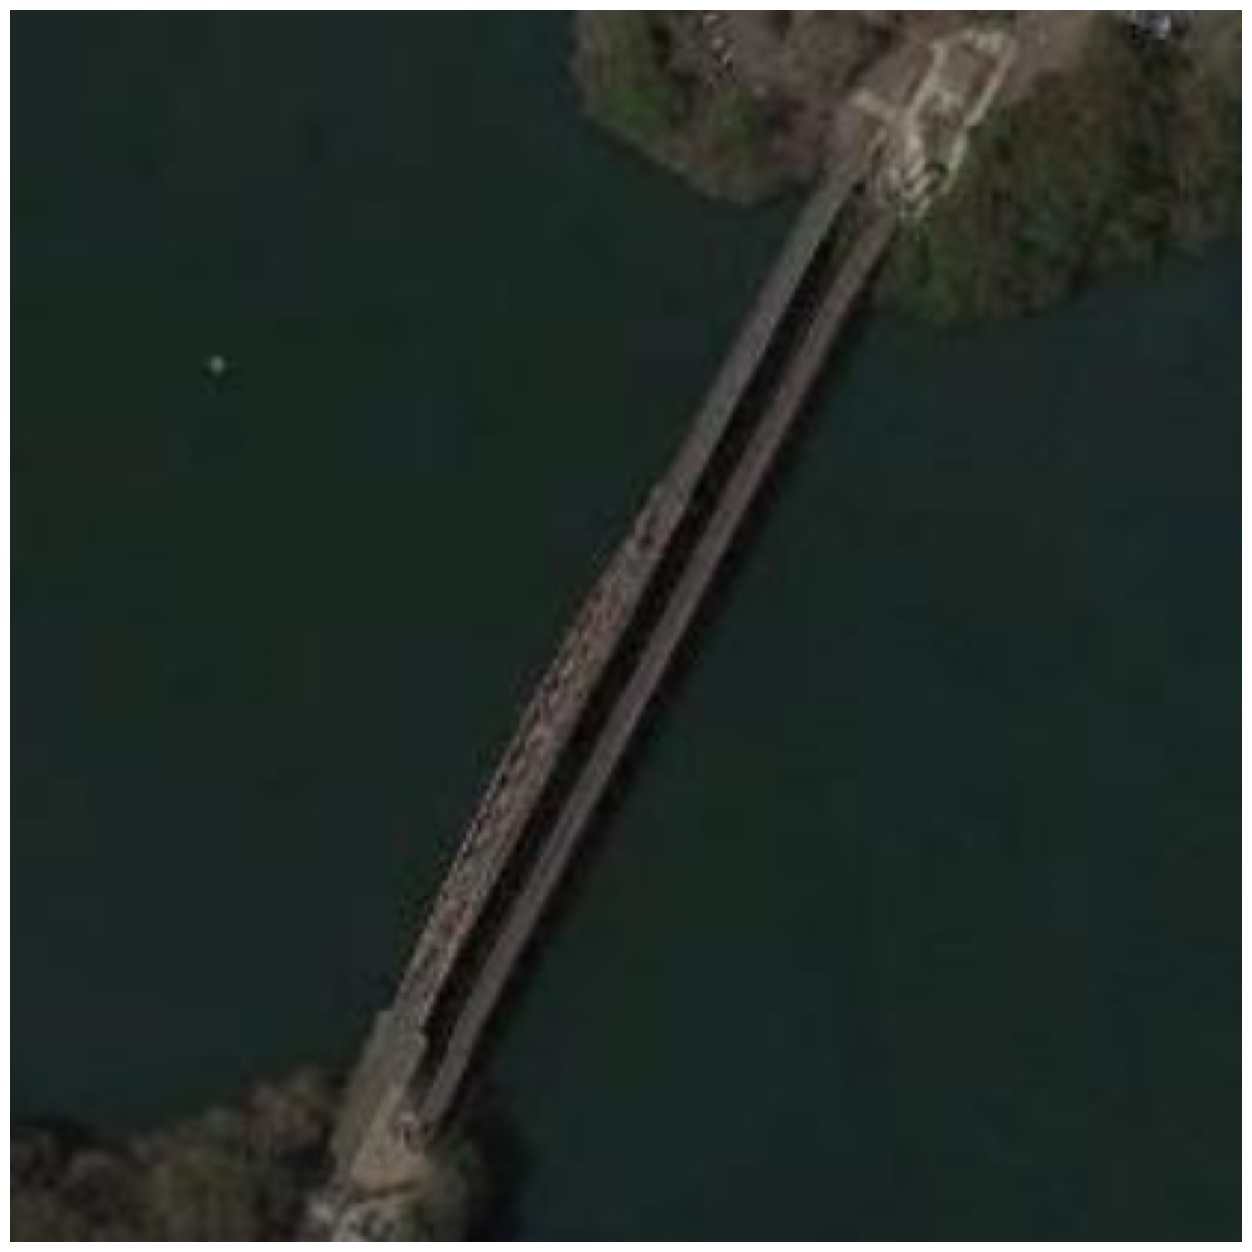

********************

Image 0: /home/pravaig-20/Downloads/Assignment_CVML_02_04_24/Assignment/datasets/RESISC45_partial/bridge/bridge_001.jpg


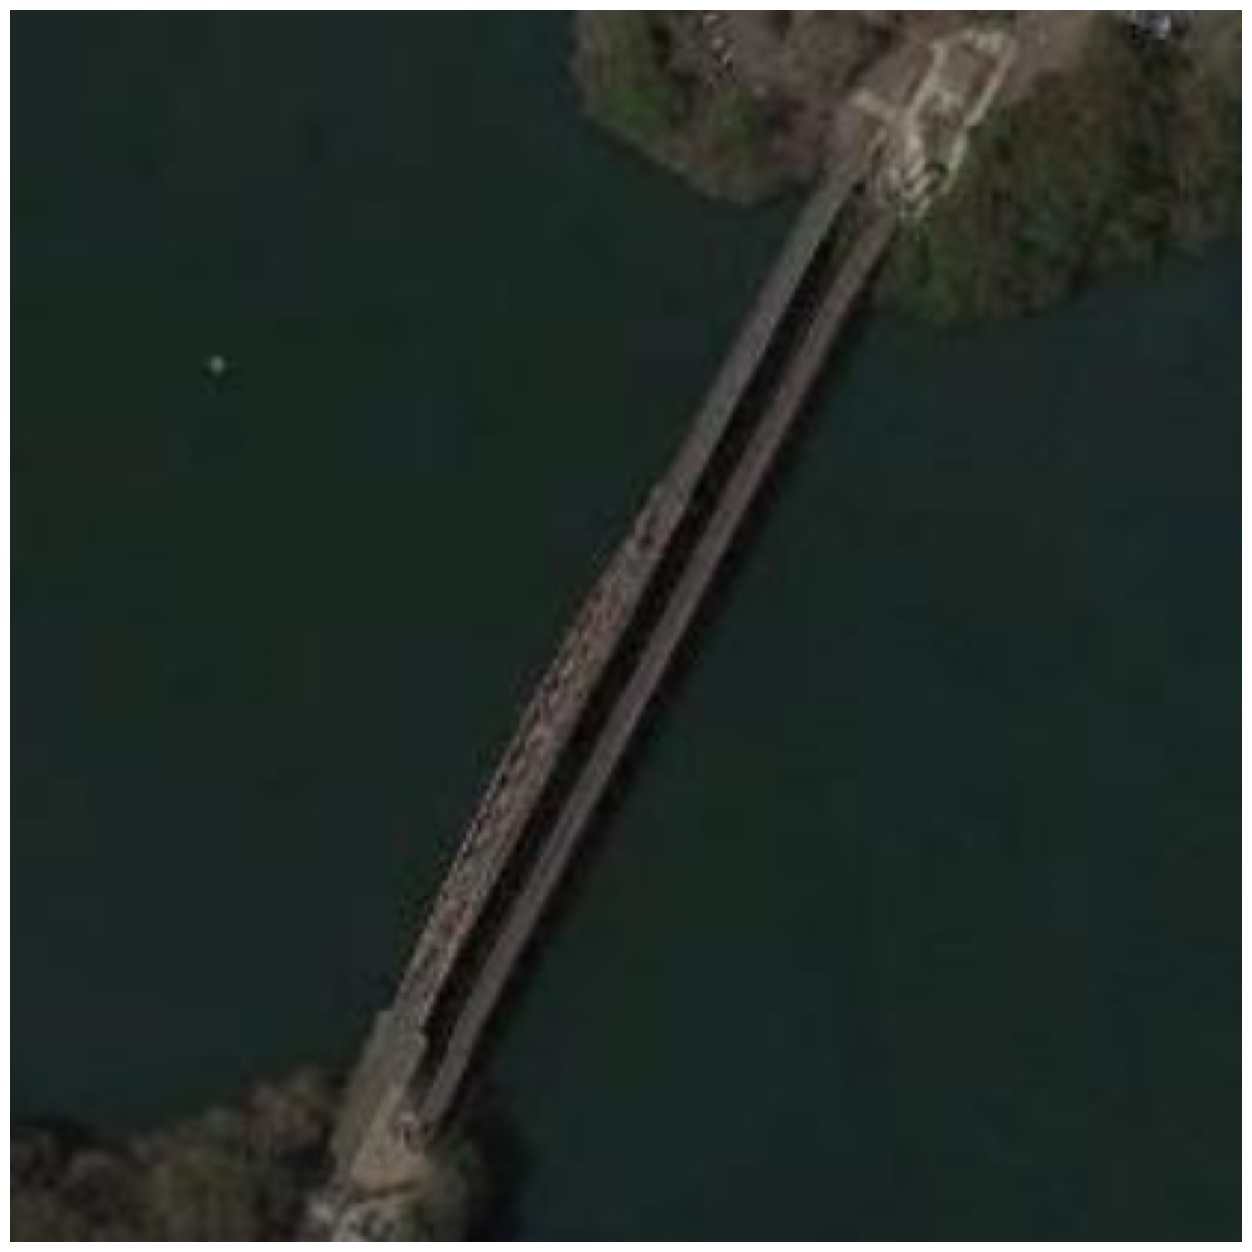


Image 1: /home/pravaig-20/Downloads/Assignment_CVML_02_04_24/Assignment/datasets/RESISC45_partial/bridge/bridge_503.jpg


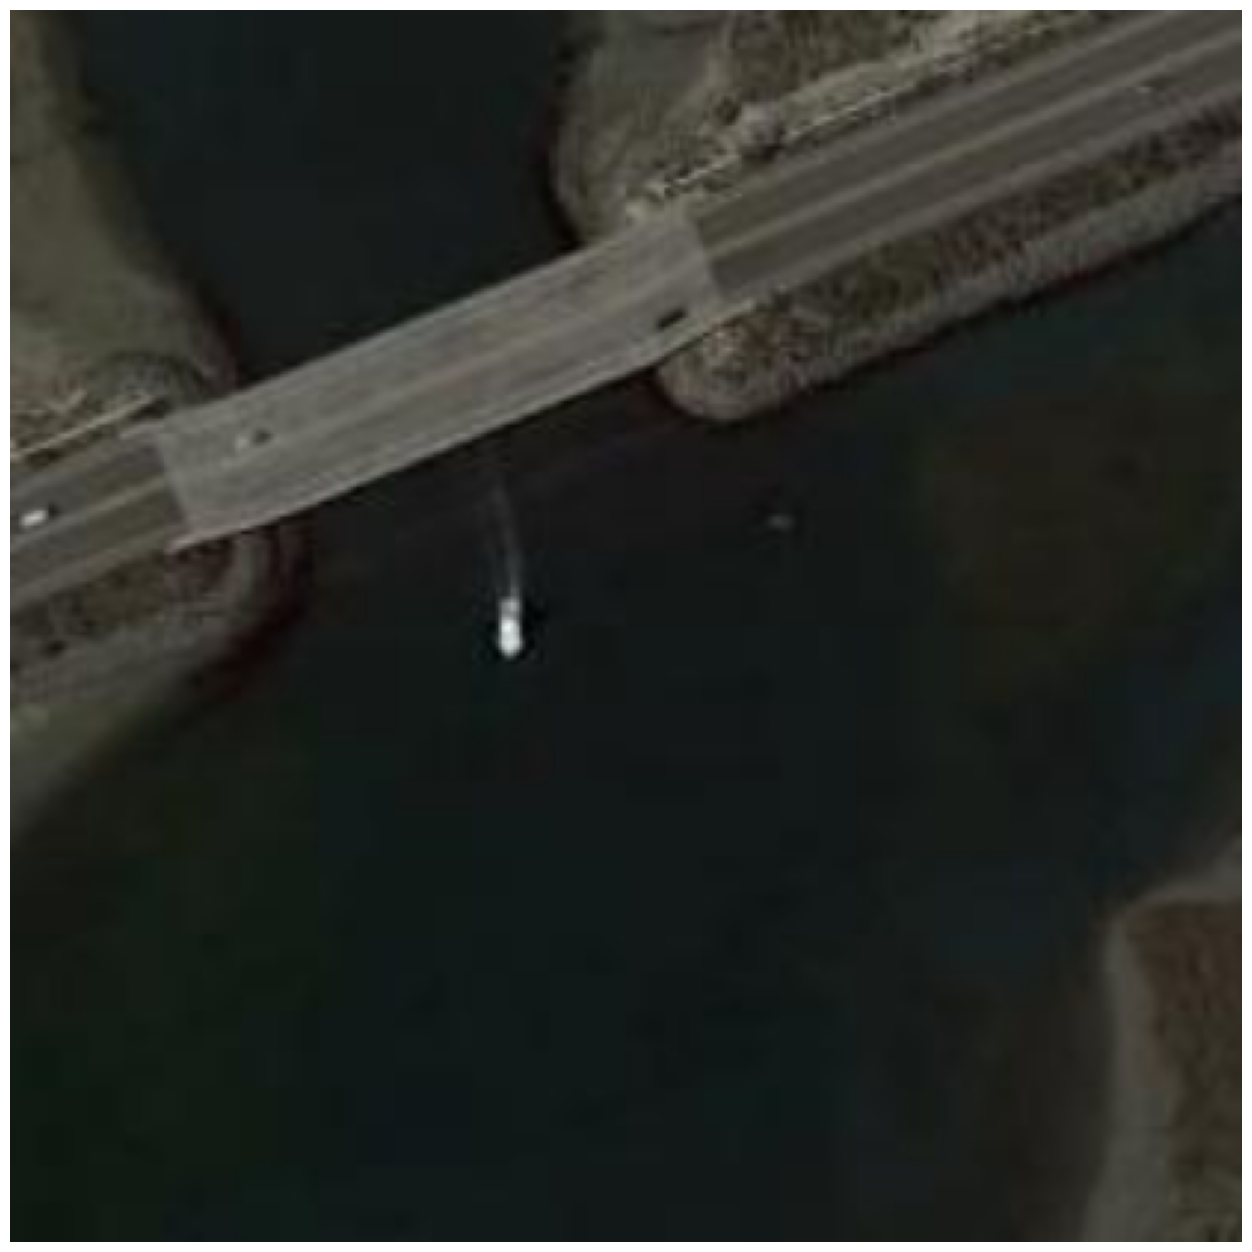


Image 2: /home/pravaig-20/Downloads/Assignment_CVML_02_04_24/Assignment/datasets/RESISC45_partial/bridge/bridge_635.jpg


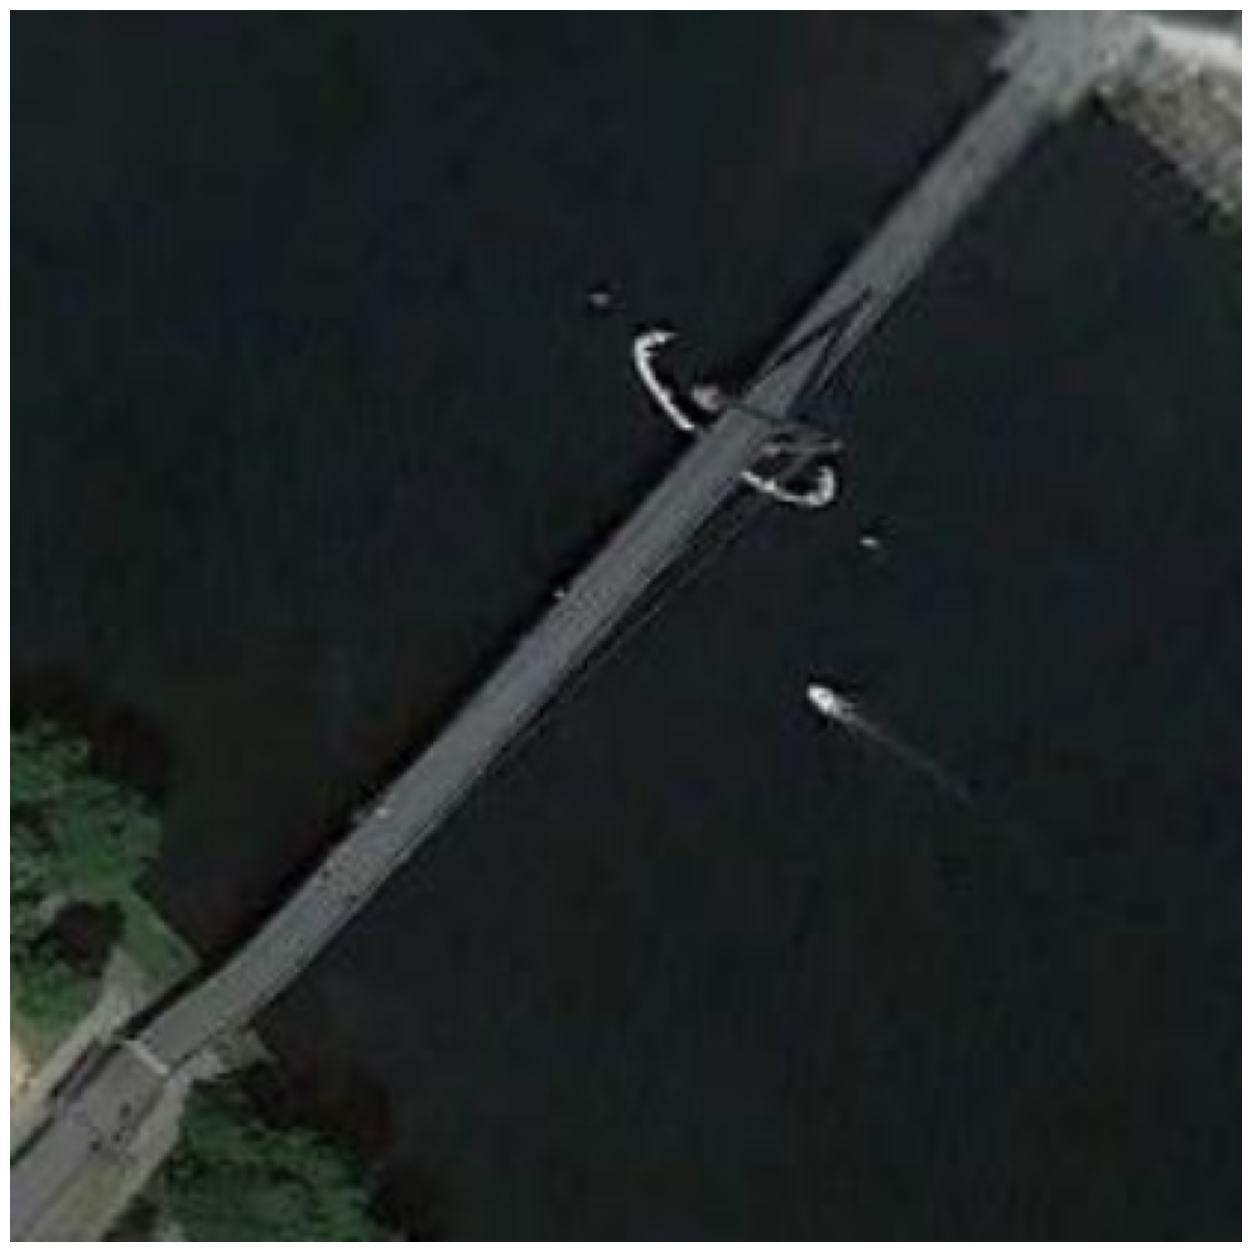

In [33]:
search_file = "/home/pravaig-20/Downloads/Assignment_CVML_02_04_24/Assignment/datasets/RESISC45_partial/bridge/bridge_001.jpg"

img = cv2.resize(cv2.imread(search_file), (416, 416)) 

print("Input image:")

%matplotlib inline
sv.plot_image(image=img, size=(16, 16))

print("*" * 20)

with torch.no_grad():
    embedding = dinov2_vits14(load_image(search_file).to(device))

    indices = search_index(data_index, np.array(embedding[0].cpu()).reshape(1, -1))

    for i, index in enumerate(indices):
        print()
        print(f"Image {i}: {files[index]}")
        img = cv2.resize(cv2.imread(files[index]), (416, 416)) 
        %matplotlib inline
        sv.plot_image(image=img, size=(16, 16))

## 🏆 Congratulations

### Learning Resources

Roboflow has produced many resources that you may find interesting as you advance your knowledge of computer vision:

- [Roboflow Notebooks](https://github.com/roboflow/notebooks): A repository of over 20 notebooks that walk through how to train custom models with a range of model types, from YOLOv7 to SegFormer.
- [Roboflow YouTube](https://www.youtube.com/c/Roboflow): Our library of videos featuring deep dives into the latest in computer vision, detailed tutorials that accompany our notebooks, and more.
- [Roboflow Discuss](https://discuss.roboflow.com/): Have a question about how to do something on Roboflow? Ask your question on our discussion forum.
- [Roboflow Models](https://roboflow.com): Learn about state-of-the-art models and their performance. Find links and tutorials to guide your learning.

### Convert data formats

Roboflow provides free utilities to convert data between dozens of popular computer vision formats. Check out [Roboflow Formats](https://roboflow.com/formats) to find tutorials on how to convert data between formats in a few clicks.

### Connect computer vision to your project logic

[Roboflow Templates](https://roboflow.com/templates) is a public gallery of code snippets that you can use to connect computer vision to your project logic. Code snippets range from sending emails after inference to measuring object distance between detections.